matching the unmasked imgs with  masked imgs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import re

## Unet

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import glob
from PIL import Image


In [ ]:
class ImageDataset(Dataset):
    def __init__(self,root_masked,root_binary,transform=None):
        self.transform = transform
        self.files_masked = sorted(glob.glob(root_masked+"/*.*"))
        self.files_binary = sorted(glob.glob(root_binary+"/*.*"))

    def __getitem__(self,index):
        item_masked = self.transform(Image.open(self.files_masked[index%len(self.files_masked)]))
        item_binary = self.transform(Image.open(self.files_binary[index%len(self.files_binary)]))
        return (item_masked-0.5)*2,(item_binary-0.5)*2

    def __len__(self):
        return min(len(self.files_masked),len(self.files_binary))

In [ ]:
maskedImage ="/content/drive/MyDrive/Capstone/dataset/Dataset/OccludedImages/MaskOcclusion"
binarySeg = "/content/drive/MyDrive/Capstone/dataset/Dataset/BinarySeg/BinaryMask"


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
temp = "/content/drive/MyDrive/Capstone/occluded_51-100/mask"

In [ ]:
def resize(img):
  resImg = cv2.imread(img)
  resImg = resImg.astype(np.float32)
  resImg = cv2.resize(resImg,(224,224))
  cv2.imwrite(img,resImg)


In [ ]:
# for i in os.listdir(maskedImage):
#   path = os.path.join(maskedImage,i)
#   resize(path)

In [ ]:
s = sorted(glob.glob(maskedImage+'/*.*'))
print(s)
# s[1] = resize(s[1])

s_i = transform(Image.open(s[1]))
print(s_i.shape)

['/content/drive/MyDrive/Capstone/dataset/Dataset/OccludedImages/MaskOcclusion/001.jpg', '/content/drive/MyDrive/Capstone/dataset/Dataset/OccludedImages/MaskOcclusion/0010.jpg', '/content/drive/MyDrive/Capstone/dataset/Dataset/OccludedImages/MaskOcclusion/00100.jpg', '/content/drive/MyDrive/Capstone/dataset/Dataset/OccludedImages/MaskOcclusion/001000.jpg', '/content/drive/MyDrive/Capstone/dataset/Dataset/OccludedImages/MaskOcclusion/001001.jpg', '/content/drive/MyDrive/Capstone/dataset/Dataset/OccludedImages/MaskOcclusion/001002.jpg', '/content/drive/MyDrive/Capstone/dataset/Dataset/OccludedImages/MaskOcclusion/001003.jpg', '/content/drive/MyDrive/Capstone/dataset/Dataset/OccludedImages/MaskOcclusion/001004.jpg', '/content/drive/MyDrive/Capstone/dataset/Dataset/OccludedImages/MaskOcclusion/001005.jpg', '/content/drive/MyDrive/Capstone/dataset/Dataset/OccludedImages/MaskOcclusion/001006.jpg', '/content/drive/MyDrive/Capstone/dataset/Dataset/OccludedImages/MaskOcclusion/001007.jpg', '/co

In [ ]:
dataset = ImageDataset(maskedImage,binarySeg,transform)

In [ ]:
train = DataLoader(dataset,batch_size=1, shuffle = True)
print(train)

torch.Size([1, 3, 224, 224]) torch.Size([1, 1, 224, 224])


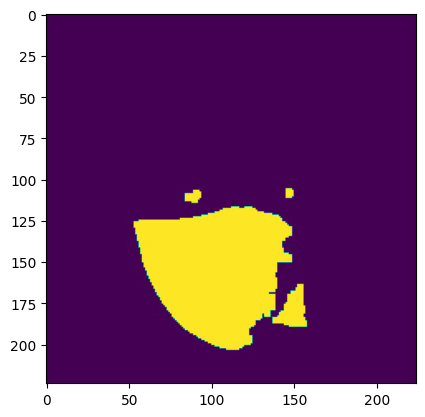

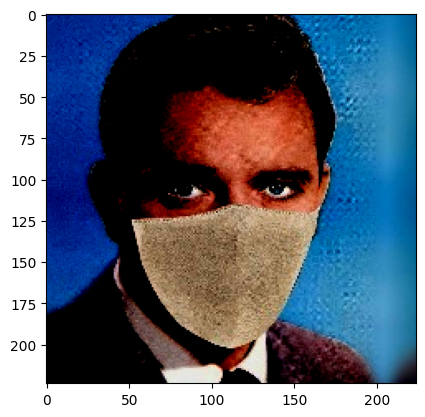

In [ ]:
train_x,train_y = next(iter(train))
print(train_x.size(),train_y.size())
Binimage = train_y[0].squeeze()
plt.imshow(Binimage)
plt.show()
Maskimage = train_x[0].squeeze()
# print(Maskimage.shape)
# t = transforms.Resize((254, 254))
Maskimage = Maskimage.permute(1,2,0)
plt.imshow(Maskimage)
plt.show()

In [ ]:
def crop(image,new_shape):
    print("in cropt",image.shape,new_shape,image.shape[2])
    middle_height = image.shape[2]//2
    middle_width = image.shape[3]//2
    starting_height = middle_height-round(new_shape[2]/2)
    final_height = starting_height+new_shape[2]
    starting_width = middle_width-round(new_shape[3]/2)
    final_width = starting_width+new_shape[3]
    cropped_image = image[:,:,starting_height:final_height,starting_width:final_width]
    return cropped_image

In [ ]:
class ContractingBlock(nn.Module):
    def __init__(self,input_channels,use_dropout=False,use_in=True):
        super(ContractingBlock,self).__init__()
        self.conv = nn.Conv2d(input_channels,input_channels*2,kernel_size=3,padding=1)
        self.activation = nn.LeakyReLU(0.2)
        self.conv = nn.Conv2d(input_channels,input_channels*2,kernel_size=3,padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        if use_in:
            self.insnorm = nn.InstanceNorm2d(input_channels*2)
        self.use_in = use_in
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self,x):
        x = self.conv(x)
        if self.use_in:
            x = self.insnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.maxpool(x)
        return x

class ExpandingBlock(nn.Module):
    def __init__(self,input_channels,use_dropout=False,use_in=True):
        super(ExpandingBlock,self).__init__()
        self.tconv = nn.ConvTranspose2d(input_channels,input_channels//2,kernel_size=3,stride=2,padding=1,output_padding=1)
        self.conv2 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=3, padding=1)
        if use_in:
            self.insnorm = nn.InstanceNorm2d(input_channels//2)
        self.use_in = use_in
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout
        self.activation = nn.LeakyReLU(0.2)

    def forward(self,x,skip_x):
        x = self.tconv(x)
        # print("IN EXPANDING BOX",skip_x.shape)
        skip_x = crop(skip_x,x.shape)
        x = torch.cat([x,skip_x],axis=1)     #really need ???
        x = self.conv2(x)
        if self.use_in:
            x = self.insnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        return x

class FeatureMapBlock(nn.Module):
    def __init__(self,input_channels,output_channels):
        super(FeatureMapBlock,self).__init__()
        self.conv = nn.Conv2d(input_channels,output_channels,kernel_size=1)

    def forward(self,x):
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self,input_channels,output_channels,hidden_channels=32):
        super(UNet,self).__init__()
        self.upfeature = FeatureMapBlock(input_channels,hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels,use_in=False)
        self.contract2 = ContractingBlock(hidden_channels*2)
        self.contract3 = ContractingBlock(hidden_channels*4)
        self.contract4 = ContractingBlock(hidden_channels*8)
        self.contract5 = ContractingBlock(hidden_channels*16)
        self.expand0 = ExpandingBlock(hidden_channels*32) #bottleneck 1024
        self.expand1 = ExpandingBlock(hidden_channels*16)
        self.expand2 = ExpandingBlock(hidden_channels*8)
        self.expand3 = ExpandingBlock(hidden_channels*4)
        self.expand4 = ExpandingBlock(hidden_channels*2)
        self.downfeature = FeatureMapBlock(hidden_channels,output_channels)
        self.tanh = torch.nn.Tanh()

    def forward(self,x):
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)    #x4:512
        x5 = self.contract5(x4)    #x5:1024
        x6 = self.expand0(x5,x4)
        x7 = self.expand1(x6,x3)
        x8 = self.expand2(x7,x2)
        x9 = self.expand3(x8,x1)
        x10 = self.expand4(x9,x0)
        xn = self.downfeature(x10)
        return self.tanh(xn)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self,input_channels,hidden_channels=8):
        super(Discriminator,self).__init__()
        self.upfeature = FeatureMapBlock(input_channels,hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels,use_in=False)
        self.contract2 = ContractingBlock(hidden_channels*2)
        self.contract3 = ContractingBlock(hidden_channels*4)
        self.contract4 = ContractingBlock(hidden_channels*8)
        self.final = nn.Conv2d(hidden_channels*16,1,kernel_size=1)   #should change?

    def forward(self,x):      ##without concat with masked img
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        xn = self.final(x4)
        return xn

In [ ]:
import torch.nn.functional as F
adv_criterion = nn.BCEWithLogitsLoss() #loss function for binary classification BInary cross entropy loss
recon_criterion = nn.L1Loss()
lambda_recon = 200

n_epochs=10
input_dim = 3
binary_dim = 1         # (-1,1,224,224)
display_step = 1000
batch_size = 2
lr = 0.0002 #learning rate
target_shape = 224
device = "cuda"


transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = ImageDataset(maskedImage,binarySeg,transform)

In [ ]:

gen = UNet(input_dim,binary_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(),lr=lr)
disc = Discriminator(binary_dim).to(device)
disc_opt = torch.optim.Adam(disc.parameters(),lr=lr)
def weights_init(m):
    if isinstance(m,nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight,0.0,0.02)
#     if isinstance(m,nn.InstanceNorm2d):
#         torch.nn.init.normal_(m.weight,0.0,0.02)
#         torch.nn.init.constant_(m.bias,0)

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

RuntimeError: ignored

In [ ]:
def get_gen_loss(gen,disc,binary,masked,adv_criterion,recon_criterion,lambda_recon):
    fake = gen(masked)
    pred = disc(fake)
    adv_loss = adv_criterion(pred,torch.ones_like(pred))#nn.BCEWithLogitsLoss()
    recon_loss = recon_criterion(fake,binary)#L1Loss
    gen_loss = adv_loss+(lambda_recon*recon_loss)
    return gen_loss

def get_disc_loss(disc,fake,binary,adv_criterion):
    fake_pred = disc(fake.detach())
    binary_pred = disc(binary)
    fake_loss = adv_criterion(fake_pred,torch.zeros_like(fake_pred))
    binary_loss = adv_criterion(binary_pred,torch.ones_like(binary_pred))
    disc_loss = (fake_loss+binary_loss)/2
    return disc_loss

In [ ]:
def show_tensor_images(image_tensor, num_images=3, size=(3,224,224)):
    image_tensor = (image_tensor + 1) / 2
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [ ]:
def train(save_model=True):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    dataloader = DataLoader(dataset,batch_size=1,shuffle = True)
    cur_step = 0

    for epoch in range(n_epochs):
        for masked,binary in tqdm(dataloader):
            cur_batch_size=len(masked)
            masked = masked.to(device)
            binary = binary.to(device)

            disc_opt.zero_grad()      ##update discriminator
            with torch.no_grad():
                fake = gen(masked)
            disc_loss = get_disc_loss(disc,fake,binary,adv_criterion)
            disc_loss.backward(retain_graph=True)
            disc_opt.step()

            gen_opt.zero_grad()

            # print(masked.shape,"here",binary.shape)
            gen_loss = get_gen_loss(gen,disc,binary,masked,adv_criterion,recon_criterion,lambda_recon)
            gen_loss.backward()
            gen_opt.step()

            mean_discriminator_loss += disc_loss.item()/display_step
            mean_generator_loss +=gen_loss.item()/display_step

            if cur_step%display_step == 0:
                print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
                show_tensor_images(masked,size=(input_dim,target_shape,target_shape))
                show_tensor_images(binary,size=(binary_dim,target_shape,target_shape))
                show_tensor_images(fake,size=(binary_dim,target_shape,target_shape))
                mean_generator_loss = 0
                mean_discriminator_loss = 0

            cur_step += 1

        if save_model:
            torch.save({'gen':gen.state_dict(),
                       'gen_opt':gen_opt.state_dict(),
                       'disc':disc.state_dict(),
                       'disc_opt':disc_opt.state_dict()},f"/content/drive/MyDrive/Capstone/Model/unettest_{cur_step}.pth")

  0%|          | 0/2493 [00:00<?, ?it/s]

Epoch 0: Step 0: Generator (U-Net) loss: 0.1754588623046875, Discriminator loss: 0.0006093531847000122


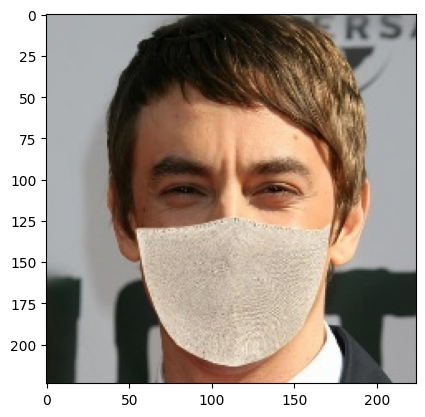

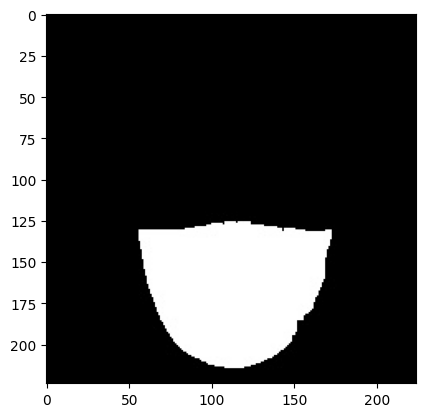

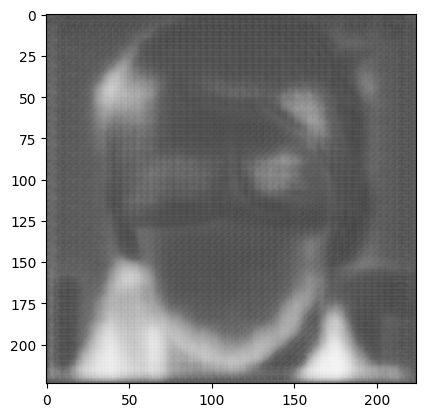

Epoch 0: Step 1000: Generator (U-Net) loss: 49.214734491348366, Discriminator loss: 0.31701959931105367


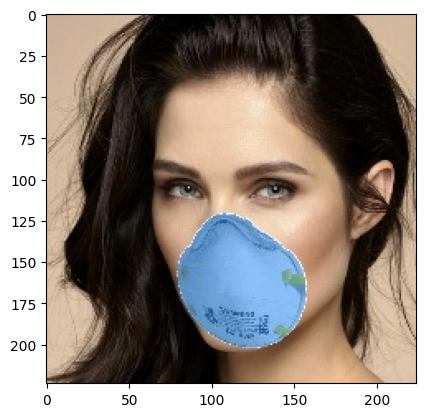

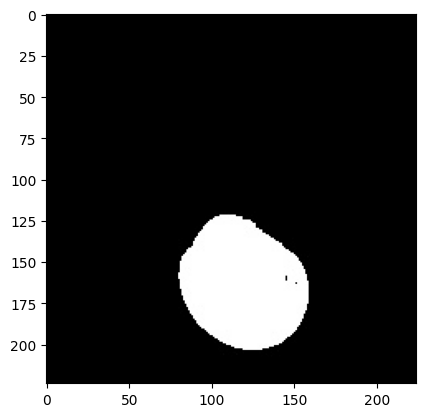

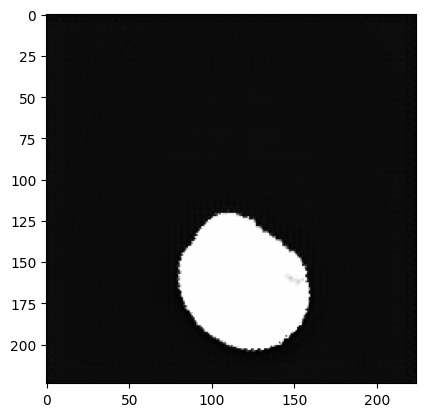

Epoch 0: Step 2000: Generator (U-Net) loss: 11.451516832351675, Discriminator loss: 0.4318769499510527


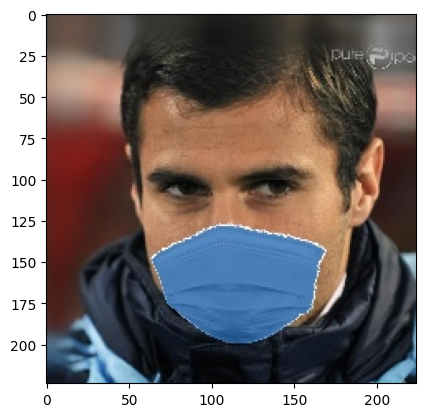

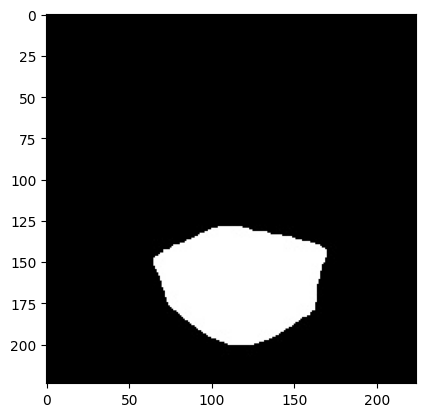

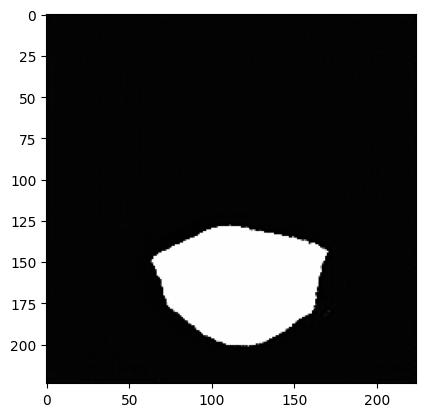

  0%|          | 0/2493 [00:00<?, ?it/s]

Epoch 1: Step 3000: Generator (U-Net) loss: 5.998745114088064, Discriminator loss: 0.49422263494133867


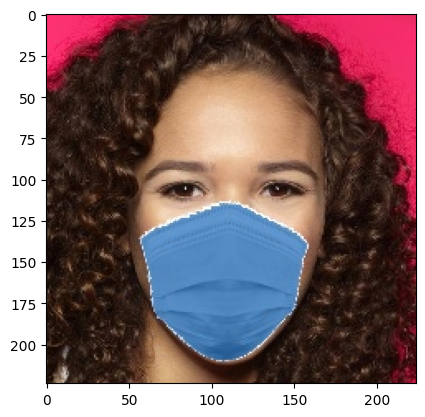

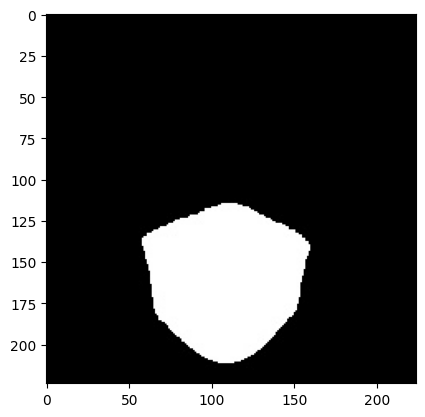

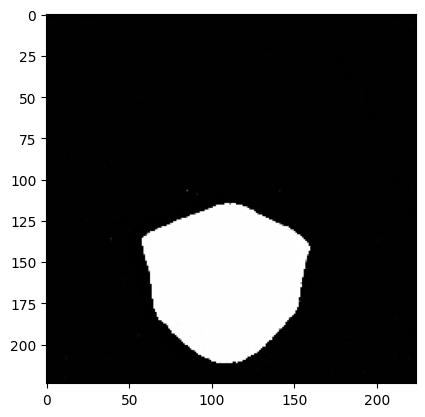

Epoch 1: Step 4000: Generator (U-Net) loss: 3.760911797761922, Discriminator loss: 0.5461791403889653


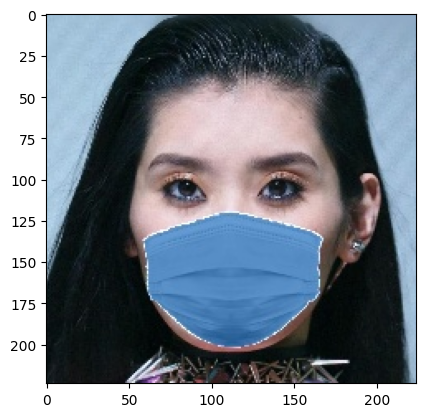

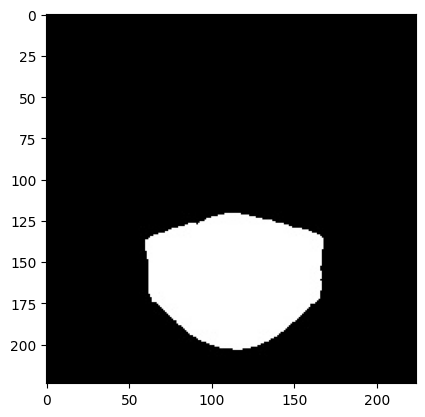

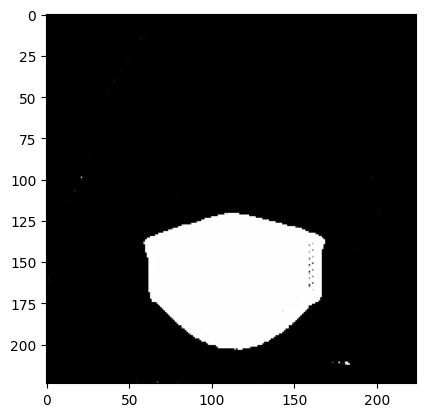

  0%|          | 0/2493 [00:00<?, ?it/s]

Epoch 2: Step 5000: Generator (U-Net) loss: 3.161632187724113, Discriminator loss: 0.5517504903823143


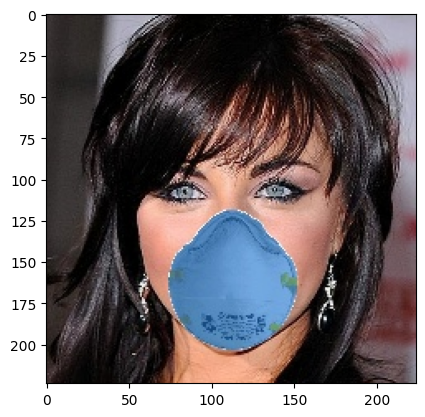

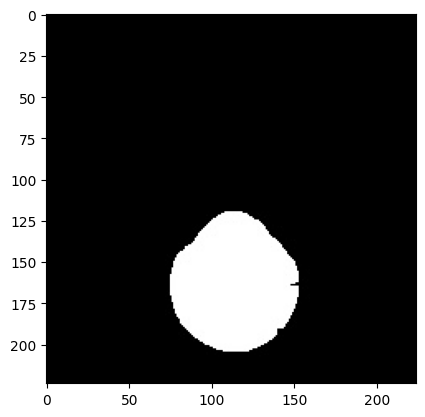

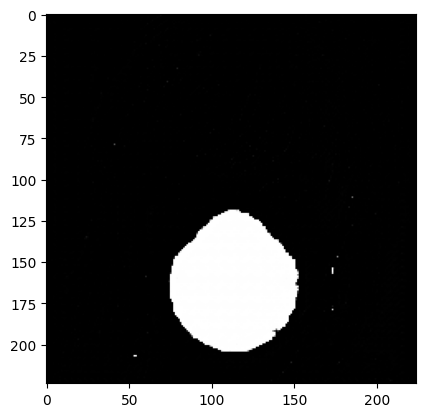

Epoch 2: Step 6000: Generator (U-Net) loss: 3.043501635909082, Discriminator loss: 0.5144606062918894


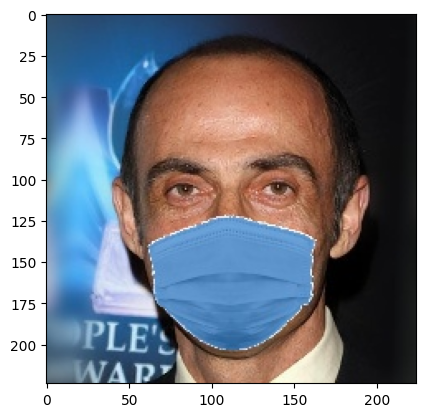

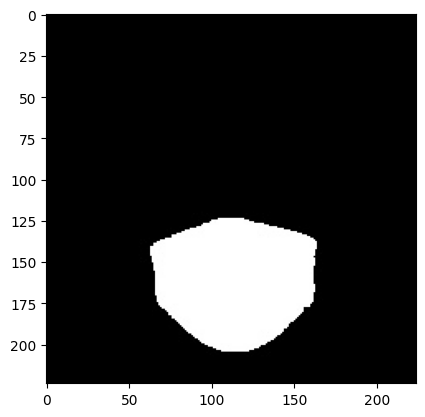

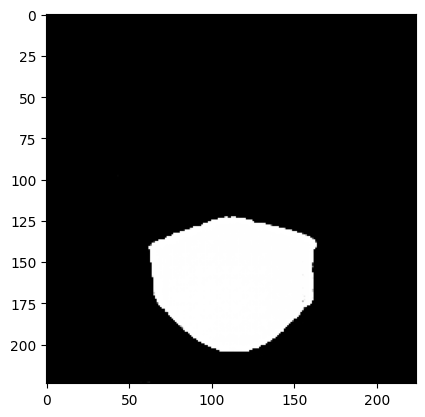

Epoch 2: Step 7000: Generator (U-Net) loss: 2.9270417993068687, Discriminator loss: 0.4914462269246582


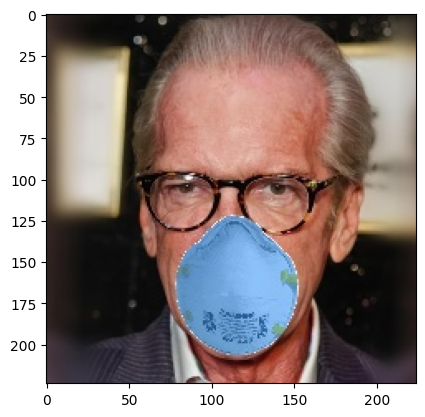

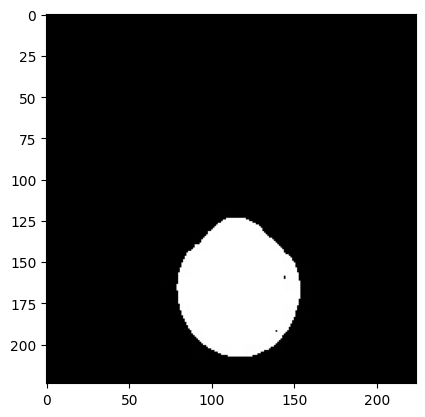

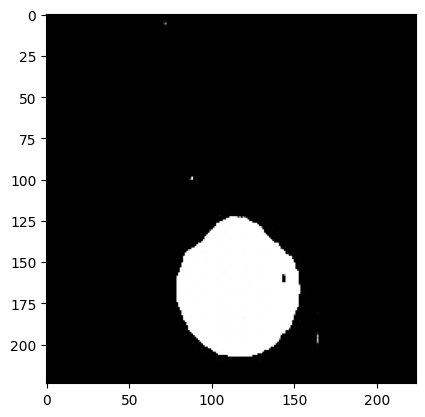

  0%|          | 0/2493 [00:00<?, ?it/s]

Epoch 3: Step 8000: Generator (U-Net) loss: 2.9642317556142808, Discriminator loss: 0.49485773834586166


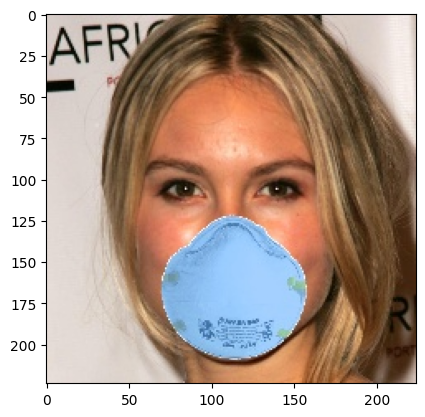

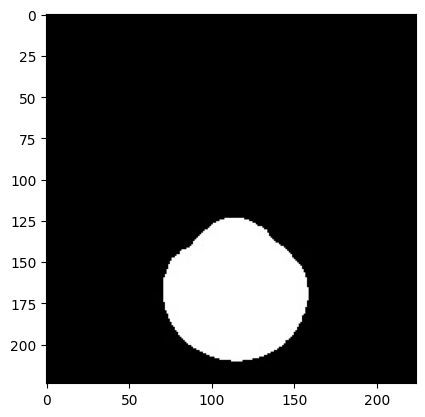

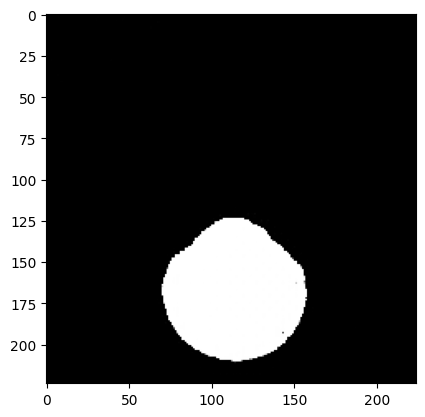

Epoch 3: Step 9000: Generator (U-Net) loss: 2.762670191526415, Discriminator loss: 0.4878399148136381


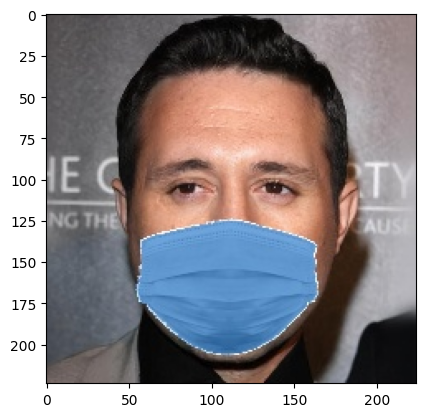

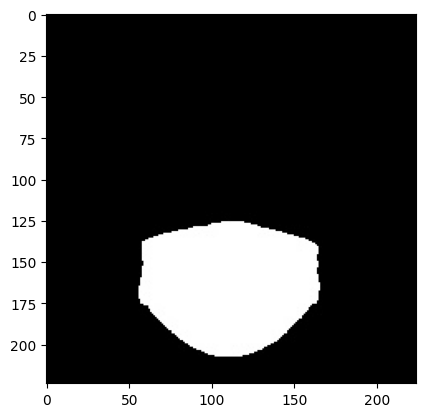

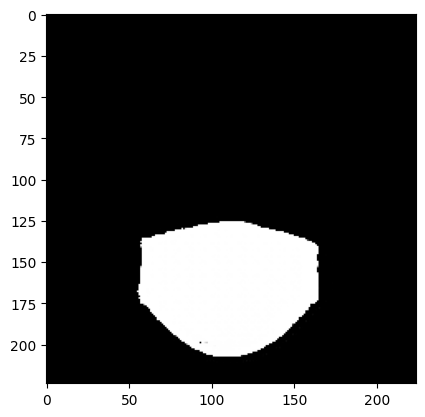

  0%|          | 0/2493 [00:00<?, ?it/s]

Epoch 4: Step 10000: Generator (U-Net) loss: 2.8921549447774866, Discriminator loss: 0.47972270345687873


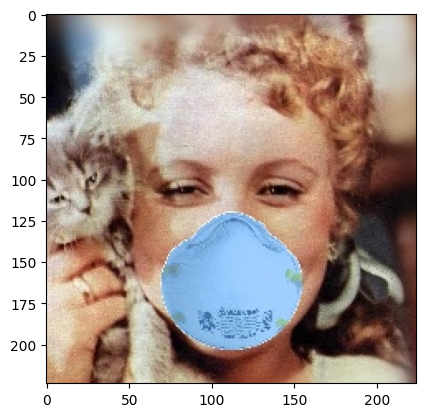

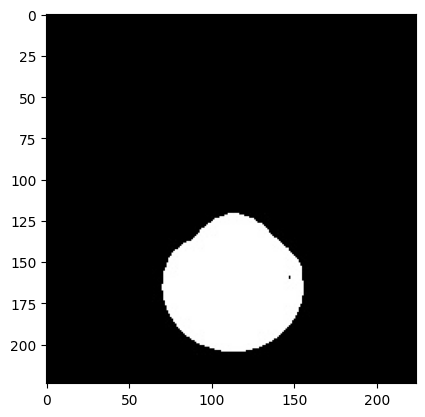

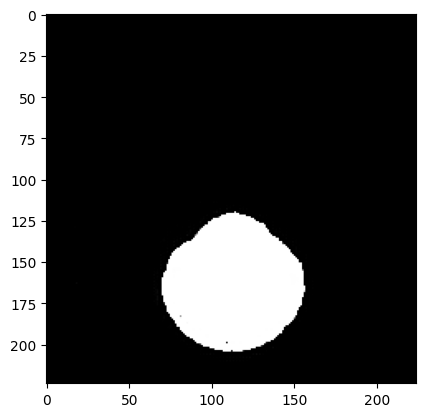

Epoch 4: Step 11000: Generator (U-Net) loss: 3.3555420755147938, Discriminator loss: 0.42215943153947594


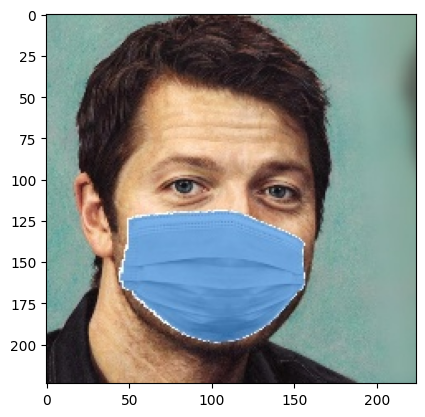

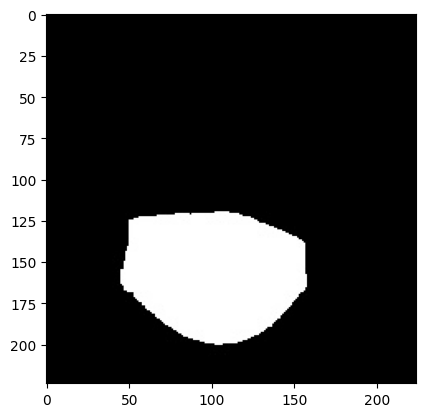

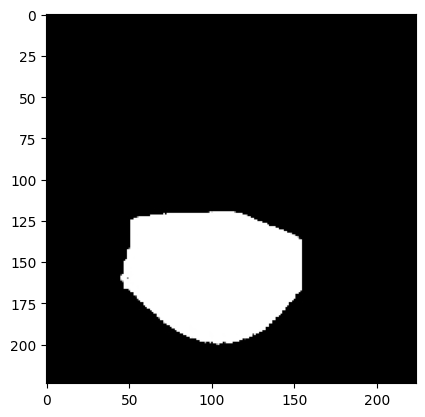

Epoch 4: Step 12000: Generator (U-Net) loss: 2.9098785409331303, Discriminator loss: 0.44884279311448294


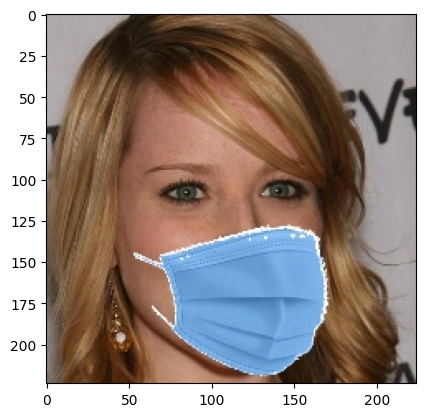

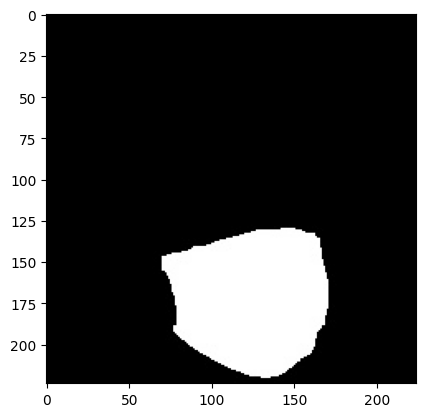

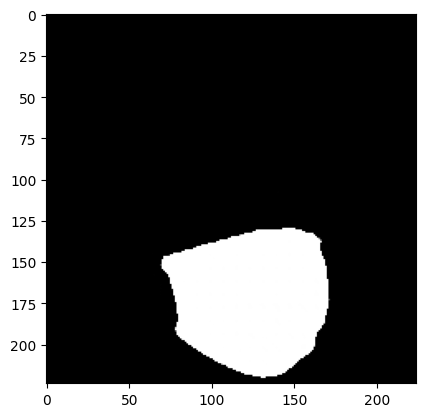

  0%|          | 0/2493 [00:00<?, ?it/s]

Epoch 5: Step 13000: Generator (U-Net) loss: 3.431078357398512, Discriminator loss: 0.4029345972090961


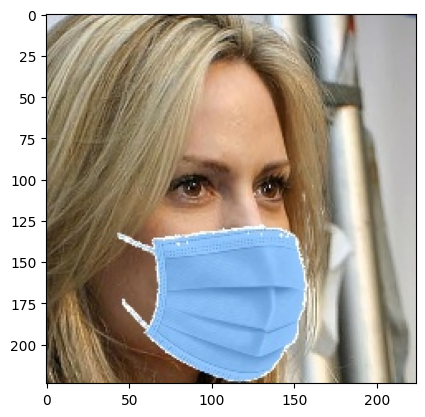

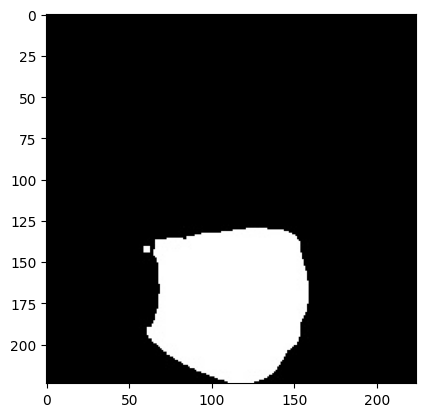

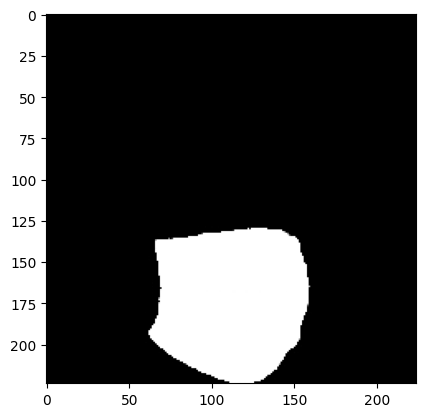

Epoch 5: Step 14000: Generator (U-Net) loss: 1.4886883919835092, Discriminator loss: 0.691460022628307


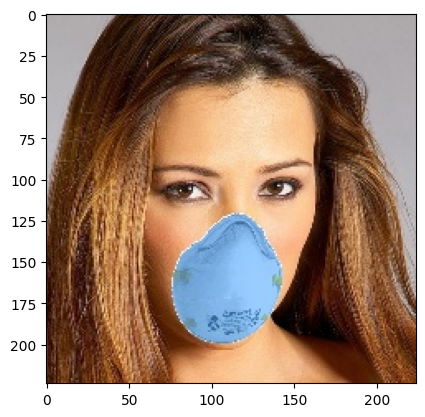

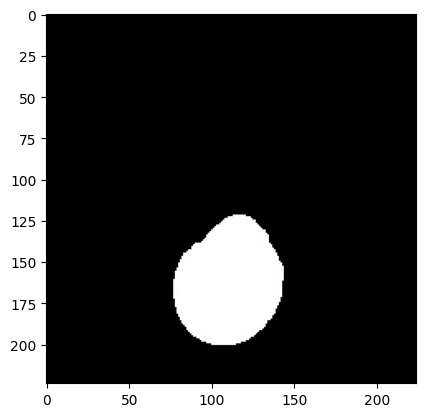

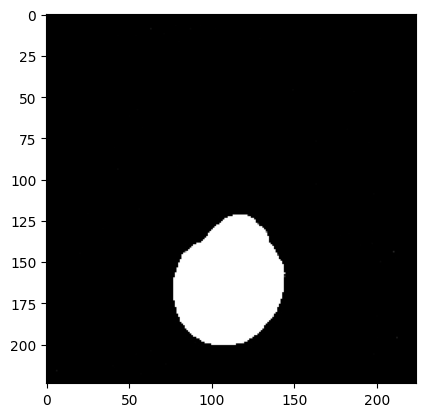

  0%|          | 0/2493 [00:00<?, ?it/s]

Epoch 6: Step 15000: Generator (U-Net) loss: 1.6395150644183165, Discriminator loss: 0.6528310829997059


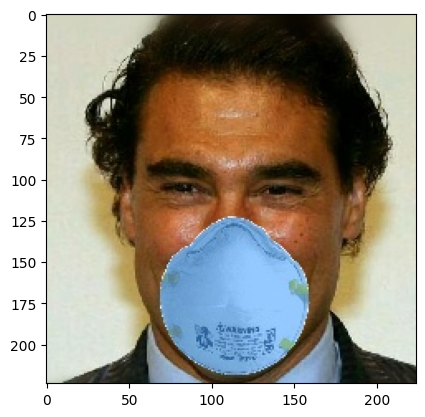

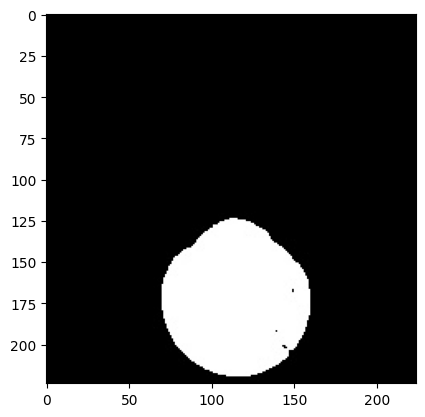

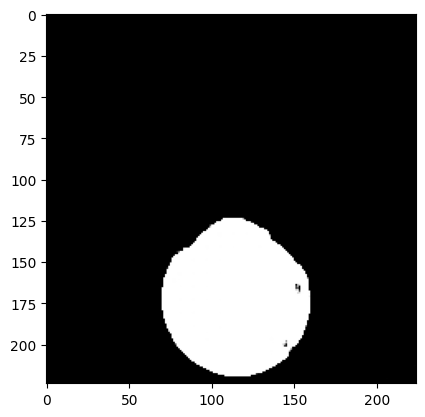

Epoch 6: Step 16000: Generator (U-Net) loss: 3.2983772466182675, Discriminator loss: 0.4271224177777762


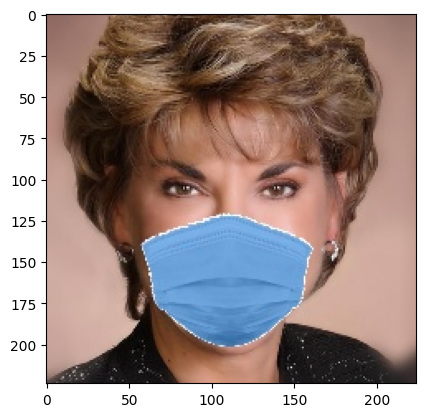

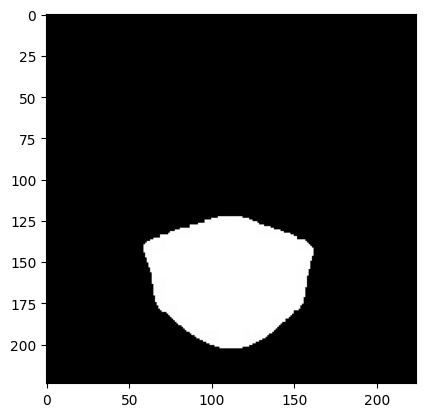

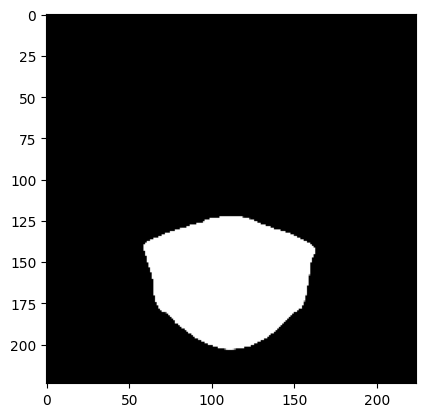

Epoch 6: Step 17000: Generator (U-Net) loss: 3.4126284301877003, Discriminator loss: 0.3593790767043827


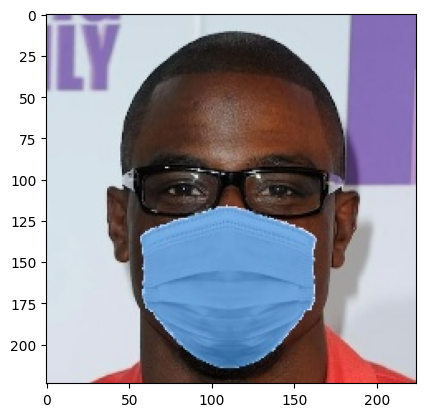

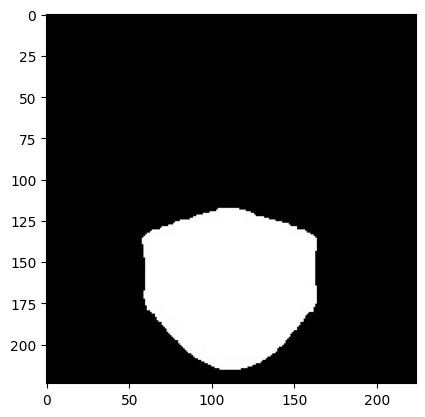

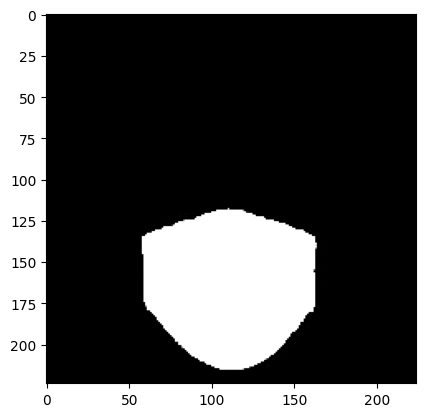

  0%|          | 0/2493 [00:00<?, ?it/s]

Epoch 7: Step 18000: Generator (U-Net) loss: 3.7658396221399304, Discriminator loss: 0.34493138380348676


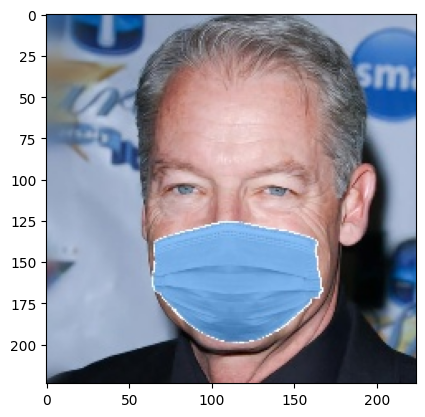

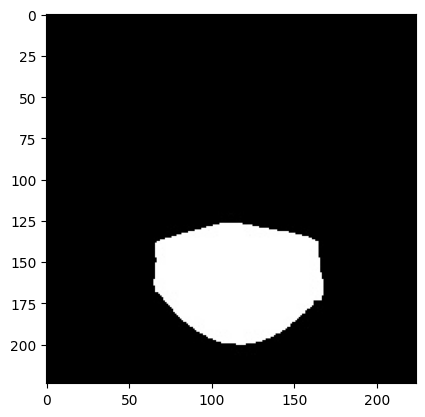

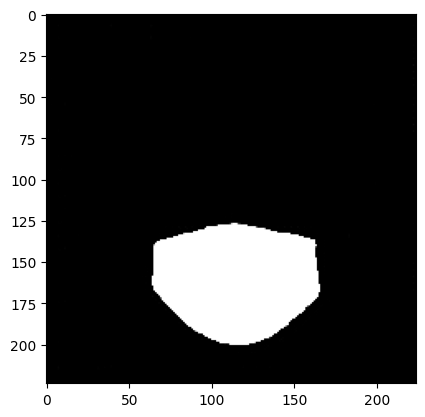

Epoch 7: Step 19000: Generator (U-Net) loss: 3.696182889938358, Discriminator loss: 0.37196710854023685


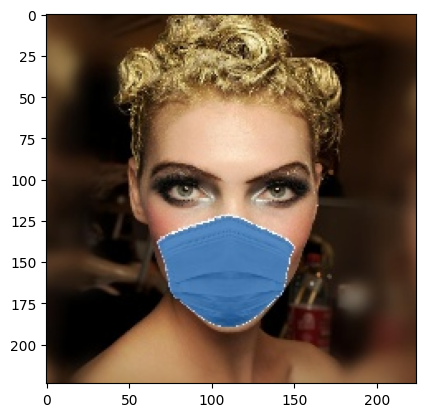

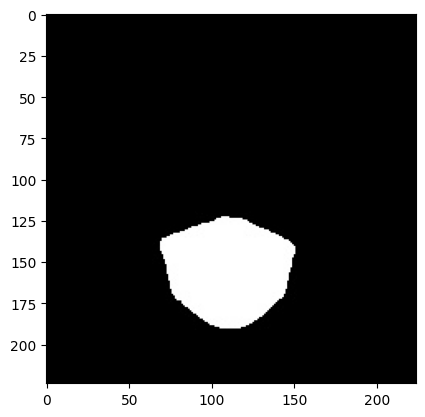

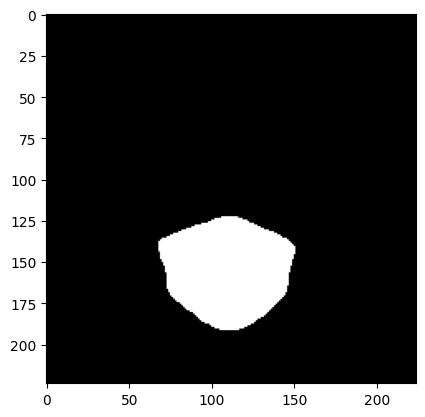

  0%|          | 0/2493 [00:00<?, ?it/s]

Epoch 8: Step 20000: Generator (U-Net) loss: 3.819205614805218, Discriminator loss: 0.34797759826853886


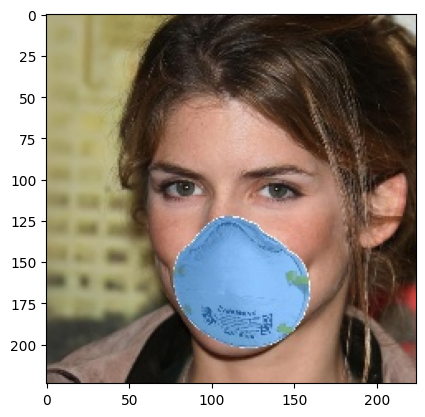

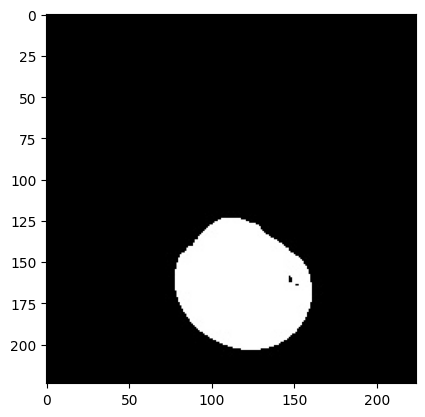

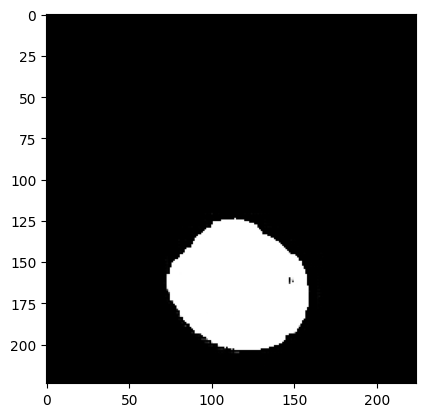

Epoch 8: Step 21000: Generator (U-Net) loss: 4.575485397696494, Discriminator loss: 0.2508180714100595


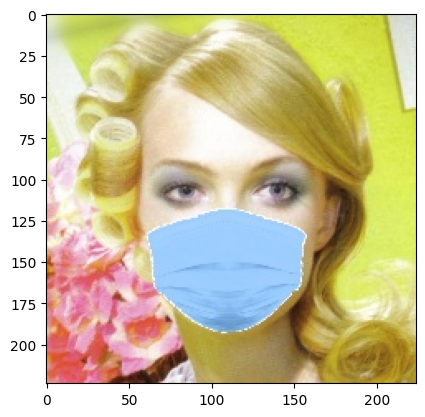

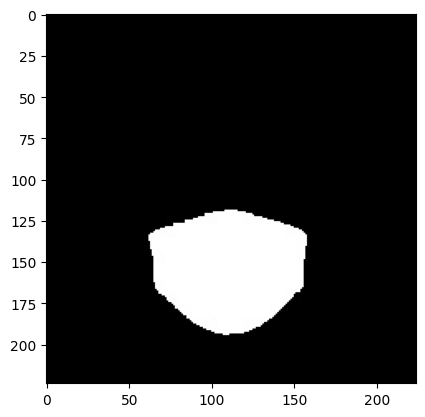

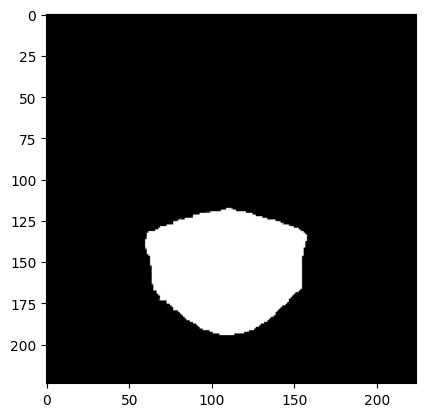

Epoch 8: Step 22000: Generator (U-Net) loss: 4.234047038793566, Discriminator loss: 0.2955483608432118


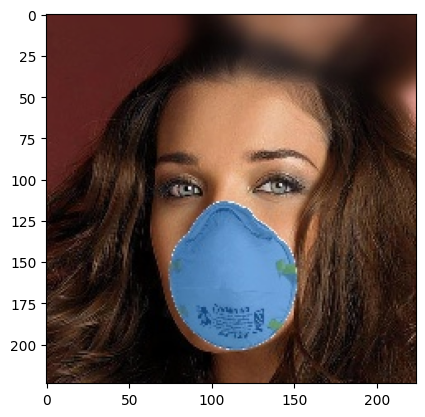

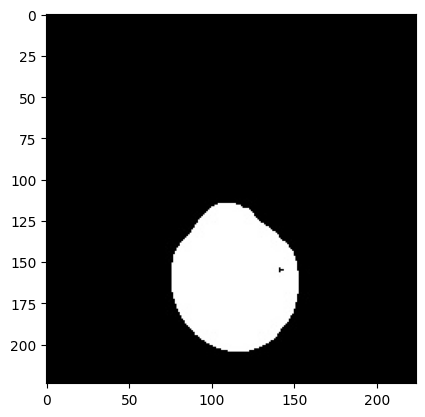

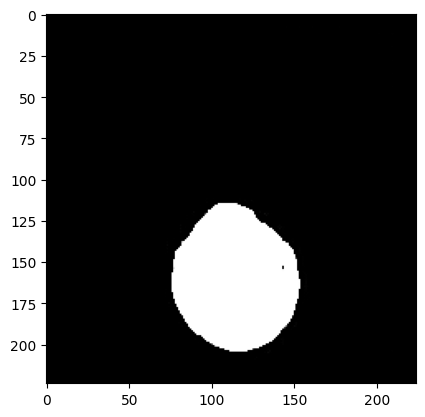

  0%|          | 0/2493 [00:00<?, ?it/s]

Epoch 9: Step 23000: Generator (U-Net) loss: 4.048013157188894, Discriminator loss: 0.2706340355724097


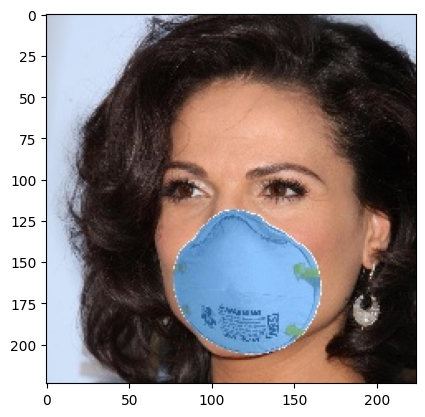

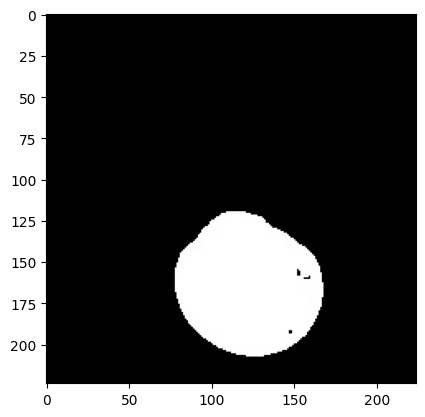

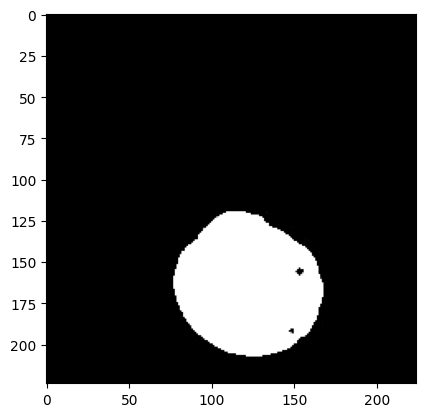

Epoch 9: Step 24000: Generator (U-Net) loss: 4.071586566090584, Discriminator loss: 0.25836272397637355


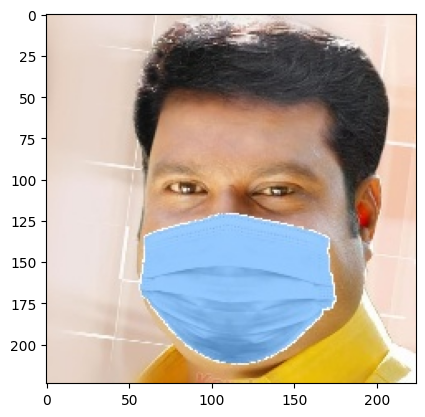

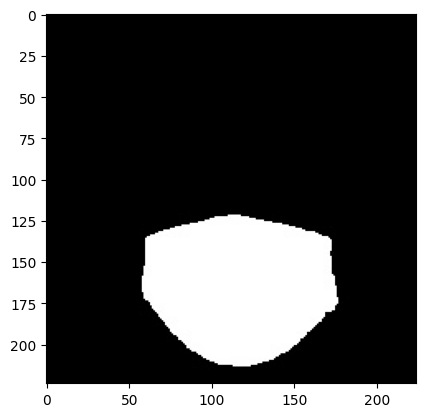

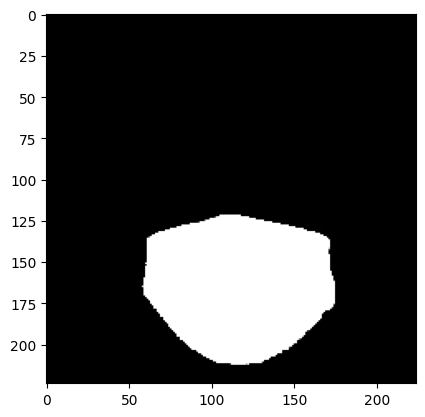

In [ ]:
train()

In [ ]:
path = "/content/002.jpg"
img = cv2.imread(path)
img = cv2.resize(img,(224,224))
cv2.imwrite("/content/002.jpg",img)

True

torch.Size([1, 3, 224, 224]) torch.Size([1, 1, 224, 224])


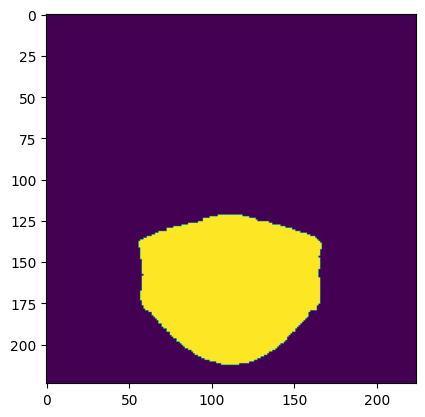

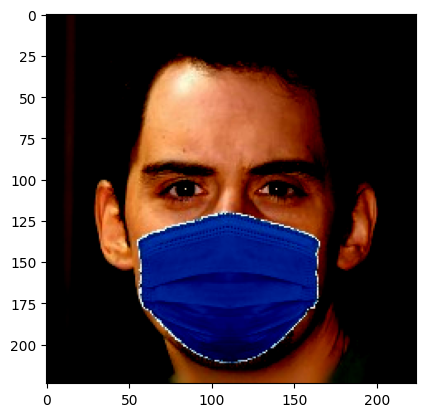

In [ ]:
train_x,train_y = next(iter(trainData))
print(train_x.size(),train_y.size())
Binimage = train_y[0].squeeze()
plt.imshow(Binimage)
plt.show()
Maskimage = train_x[0].squeeze()
# print(Maskimage.shape)
# t = transforms.Resize((254, 254))
Maskimage = Maskimage.permute(1,2,0)
plt.imshow(Maskimage)
plt.show()

In [ ]:
print()

In [ ]:
loaded_state = torch.load("/content/drive/MyDrive/Capstone/Model/unettest_24930.pth",map_location=torch.device('cpu'))
gen.load_state_dict(loaded_state["gen"])
gen_opt.load_state_dict(loaded_state["gen_opt"])
disc.load_state_dict(loaded_state["disc"])
disc_opt.load_state_dict(loaded_state["disc_opt"])

In [ ]:
input_image_path = '/content/sample8.jpeg'  # Replace with the path to your input image
input_image = Image.open(input_image_path)
input_tensor = transform(input_image).unsqueeze(0)  # Add a batch dimension (1, C, H, W)
# Move the input tensor to the same device as the generator (CPU or GPU)
input_tensor = input_tensor.to(device)

# Set the generator to evaluation mode
gen.eval()

# Perform inference
with torch.no_grad():
    generated_output = gen(input_tensor)
# Convert the generated output to a PIL Image
generated_image = transforms.ToPILImage()(generated_output.squeeze(0).cpu())

# Save the generated image
generated_image.save('/content/res/002.jpg')


in cropt torch.Size([1, 512, 22, 18]) torch.Size([1, 512, 22, 18]) 22
in cropt torch.Size([1, 256, 44, 37]) torch.Size([1, 256, 44, 36]) 44
in cropt torch.Size([1, 128, 88, 74]) torch.Size([1, 128, 88, 72]) 88
in cropt torch.Size([1, 64, 176, 149]) torch.Size([1, 64, 176, 144]) 176
in cropt torch.Size([1, 32, 352, 298]) torch.Size([1, 32, 352, 288]) 352
